In [3]:
import pandas as pd
import numpy as np
import sqlite3
import json

cnx = sqlite3.connect('./skills_forecasts.base.sqlite') # whole db connection

In [4]:
df_demand_main = pd.read_sql_query("SELECT * FROM Demand", cnx)
df_supply_main = pd.read_sql_query("SELECT * FROM Supply", cnx)

In [5]:
df_demand = df_demand_main.copy()
df_supply = df_supply_main.copy()

In [6]:
df_lookup = pd.read_sql_query("SELECT * FROM lookups", cnx)
df_lookup[df_lookup['name']=='Luxembourg'] # Use this --value-- to filter the main table!

,variable,value,name
29,country,16,Luxembourg


In [7]:
df_demand = df_demand[df_demand['country']==16] # Extract data only for luxembourg
df_demand = df_demand[df_demand['adjustment']==1] # Extract data only for luxembourg
df_demand = df_demand.drop('country',axis=1) # Removes unuseful column
df_demand = df_demand.drop('occupation',axis=1) # Removes unuseful column
df_demand = df_demand.drop('adjustment',axis=1) # Removes unuseful column
df_demand.reset_index()
df_demand

,year,industry,qualification,weight
243540,2000,1,1,0.781730
243542,2000,1,2,0.000000
243544,2000,1,3,0.000000
243546,2000,1,1,36.893479
243548,2000,1,2,0.000000
...,...,...,...,...
16333406,2030,66,2,0.000000
16333408,2030,66,3,0.000000
16333410,2030,66,1,3.318054
16333412,2030,66,2,5.032695


In [8]:
dic = {}
for index,row in df_lookup[df_lookup['variable']=='industry'][['value','name']].iterrows():
    dic[row['value']]=row['name']
df_demand['industry'] = df_demand['industry'].map(dic)

In [9]:
with open('./mapping_industries.json', 'r') as outfile:
    json_mapping_industries=json.load(outfile)
new_mapping = {}
for key, element in json_mapping_industries.items(): 
    for subelement in element:
        new_mapping[" "+subelement+" "] = key

In [10]:
df_demand['industry'] = df_demand['industry'].map(new_mapping)
df_demand = df_demand[df_demand.year<=2020]

In [11]:
possible_industries = np.unique(df_demand['industry'])

In [12]:
df_demand = df_demand.groupby(['year','industry','qualification']).sum()
df_demand = df_demand.reset_index()

In [13]:
df_supply = df_supply[df_supply['country']==16] # Extract data only for luxembourg
df_supply = df_supply[df_supply['adjustment']==1] # Extract data only for luxembourg
df_supply = df_supply[df_supply['popLF']==2] # Extract data only for luxembourg
df_supply = df_supply.drop('country',axis=1) # Removes unuseful column
df_supply = df_supply.drop('adjustment',axis=1) # Removes unuseful column
df_supply = df_supply.drop('popLF',axis=1) # Removes unuseful column
df_supply.reset_index()
df_supply = df_supply[df_supply.year<=2020]
df_supply = df_supply.groupby(['year','qualification']).sum()
df_supply = df_supply.reset_index()
df_supply = df_supply.drop('gender',axis=1) # Removes unuseful column
df_supply = df_supply.drop('ageband',axis=1) # Removes unuseful column
df_supply

,year,qualification,weight
0,2000,1,63380.927454
1,2000,2,80061.141521
2,2000,3,41757.931025
3,2001,1,64070.748957
4,2001,2,84392.344992
...,...,...,...
58,2019,2,121255.289652
59,2019,3,133518.756934
60,2020,1,44226.000775
61,2020,2,123331.585761


In [14]:
final_ds = df_supply.merge(df_demand,on=['year','qualification'])

In [15]:
# pd.set_option('display.max_rows', 100)
# df_lookup[df_lookup['variable']=='industry']
# df_lookup[df_lookup['variable']=='occupation']
# df_lookup[df_lookup['variable']=='qualification']
# df_lookup[df_lookup['variable']=='popLF']
# df_lookup[df_lookup['variable']=='gender']
# df_lookup[df_lookup['variable']=='ageband']

In [16]:
df_statistiques = pd.read_csv("./employment_n_by_sector.csv")

In [17]:
def from_quarter_to_date(data):
    data=data.replace("1st quarter ",'01-01-')
    data=data.replace("2nd quarter ",'01-04-')
    data=data.replace("3rd quarter ",'01-07-')
    data=data.replace("4th quarter ",'01-10-')
    return data
    
df_statistiques['Month'] = df_statistiques.apply(lambda row: from_quarter_to_date(row['Month']),axis=1) 

In [24]:
import matplotlib.pyplot as plt
df_statistiques['Month'] = pd.to_datetime(df_statistiques['Month'])
# df_statistiques.drop('Total',axis=1).set_index(['Month']).plot(figsize=(20,10))

In [25]:
df_statistiques['year'] = df_statistiques.Month

In [26]:
df_statistiques = df_statistiques.groupby(df_statistiques.Month.dt.year).apply(np.mean)
df_statistiques = df_statistiques.reset_index().rename(columns={"Month": "year"}).set_index('year')

In [27]:
# df_statistiques.drop('Total',axis=1).plot(figsize=(20,10))

In [28]:
for col in df_statistiques.columns:
    df_statistiques[col + '_change_1y'] =  df_statistiques[col].pct_change()
    df_statistiques[col + '_change_2y'] =  df_statistiques[col].pct_change(2)
    df_statistiques[col + '_change_3y'] =  df_statistiques[col].pct_change(3)
    df_statistiques[col + '_change_4y'] =  df_statistiques[col].pct_change(4)
    df_statistiques[col + '_change_5y'] =  df_statistiques[col].pct_change(5)
    df_statistiques[col+' - pct_over_total'] = df_statistiques[col]/df_statistiques.Total
    if col!= 'Total':
        df_statistiques.drop(col,axis=1,inplace=True)

for col in df_statistiques.columns:
    if 'Total' in col:
        df_statistiques.drop(col,axis=1,inplace=True)
df_statistiques = df_statistiques.dropna()
df_statistiques = df_statistiques.reset_index()

In [29]:
df_totrain = df_statistiques.merge(final_ds,on=['year'])

# read fede's dataset
df_context_features = pd.read_csv("./context_features.csv")
df_totrain = df_totrain.merge(df_context_features, on=['year','industry'])

one_hot_inds = pd.get_dummies(df_totrain.industry, prefix='industry')
df_totrain = df_totrain.join(one_hot_inds)
df_totrain_with_ind = df_totrain.copy()
df_totrain = df_totrain.drop('industry',axis=1)

In [30]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import glob
import os

In [31]:
from copy import deepcopy

def preprocess(train, test, colname, scalers):
    # performin min-max scaling each continuous feature column to the range [0, 1]
    cs = MinMaxScaler()
    train[colname] = cs.fit_transform(train[[colname]])
    test[colname] = cs.transform(test[[colname]])
    scalers[colname] = deepcopy(cs)
    
def preprocess_sample(sample, scalers):
    # performin min-max scaling each continuous feature column to the range [0, 1]
    for col in scalers.keys():
        sample[col] = scalers[col].transform([sample[[col]]])[0,0]

In [32]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import argparse
import locale
import os

min_max_rd_expanse = (min(df_totrain['rnd_expense']),max(df_totrain['rnd_expense']))
train = df_totrain[df_totrain['year']<2019]
test = df_totrain[df_totrain['year']==2019]
original_test = df_totrain_with_ind[df_totrain_with_ind['year']==2019]

# Define columns to skip
skip = ['year','industry_Administrative and support service activities',
   'industry_Construction', 'industry_Financial and insurance activities',
   'industry_Industry (extractive, manufacturing, energy and waste management)',
   'industry_Information and communication', 'industry_Other activities',
   'industry_Specialized activities and support service activities',
   'industry_Wholesale, transportation, accomodation and food service activities',
             'weight_y']

scalers = {}
for column in df_totrain.columns:
    if column not in skip:
        preprocess(train, test, column, scalers)

In [33]:
X_train = train.drop(['weight_y','year'],axis=1)
y_train = train['weight_y']
X_test = test.drop(['weight_y','year'],axis=1)
y_test = test['weight_y']
original_test = original_test.drop(['year'],axis=1)

In [277]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
    return model

model = create_mlp(X_train.shape[1], regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
# train the model
print("[INFO] training model...")
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),epochs=1500, batch_size=2)

[INFO] training model...
Train on 408 samples, validate on 24 samples
Epoch 1/1500
408/408 [==============================] - 0s 1ms/sample - loss: 99.9378 - val_loss: 99.7871
Epoch 2/1500
408/408 [==============================] - 0s 808us/sample - loss: 99.3892 - val_loss: 98.6286
Epoch 3/1500
408/408 [==============================] - 0s 760us/sample - loss: 97.5018 - val_loss: 95.4094
Epoch 4/1500
408/408 [==============================] - 0s 829us/sample - loss: 93.5140 - val_loss: 89.5428
Epoch 5/1500
408/408 [==============================] - 0s 800us/sample - loss: 86.8372 - val_loss: 80.4542
Epoch 6/1500
408/408 [==============================] - 0s 803us/sample - loss: 77.0109 - val_loss: 68.7534
Epoch 7/1500
408/408 [==============================] - 0s 858us/sample - loss: 68.9569 - val_loss: 62.7489
Epoch 8/1500
408/408 [==============================] - 0s 744us/sample - loss: 64.9680 - val_loss: 60.7789
Epoch 9/1500
408/408 [==============================] - 0s 651us/sam

dict_keys(['loss', 'val_loss'])


TypeError: 'list' object is not callable

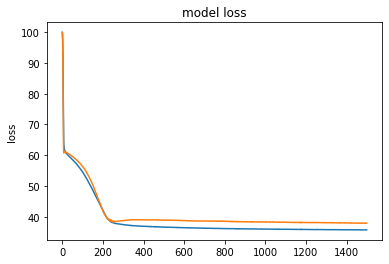

In [279]:
import matplotlib.pyplot as plt

print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [280]:
predictions = model.predict(X_test)

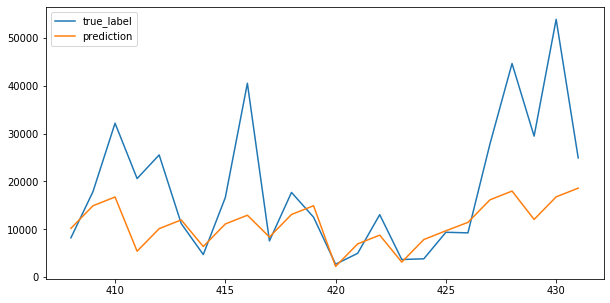

In [281]:
pd.DataFrame(data={'true_label':y_test,'prediction':predictions.reshape(1,-1)[0]}).plot(figsize=(10,5))

In [301]:
columns_to_change = ['industry']
# Make a prediction for qualification = 1,2,3 # low, medium, high
industry_values = possible_industries # set possible industries values
industry = 'Information and communication'
min_max_rd_expanse = (0,500) # set possible min max rd expeses
rd_expanse = range(100,450,50)

# pd.get_dummies(preprocessed_sample.industry, prefix='industry')
preprocessed_sample=original_test.iloc[0].copy()

values_intersection_titles = []
values_intersection = []

rep_dict = {0:'Low skill',1:'Mid skill',2:'High skill'}

for i in range(0,3):
#     for re in rd_expanse:
    for industry in possible_industries:
        skill_level = rep_dict.get(i)
        values_intersection_titles.append(skill_level+"_"+industry)
        preprocessed_sample = original_test.drop(['industry','weight_y'],axis=1).iloc[0].copy()
        preprocessed_sample['qualification'] = i
        
        ser = pd.Series()
        for inds in possible_industries:
            if industry==inds:
                preprocessed_sample['industry_'+inds]=1
            else:
                ser['industry_'+inds]=0
                
        preprocessed_sample['rnd_expense'] = re        
        preprocess_sample(preprocessed_sample, scalers)
        values_intersection.append(model.predict(np.asarray(preprocessed_sample).reshape(1, -1))[0,0])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: Deprecation

OSError: [Errno 30] Read-only file system: 'sources/hackaton/industry_demand_level_predicted.png'

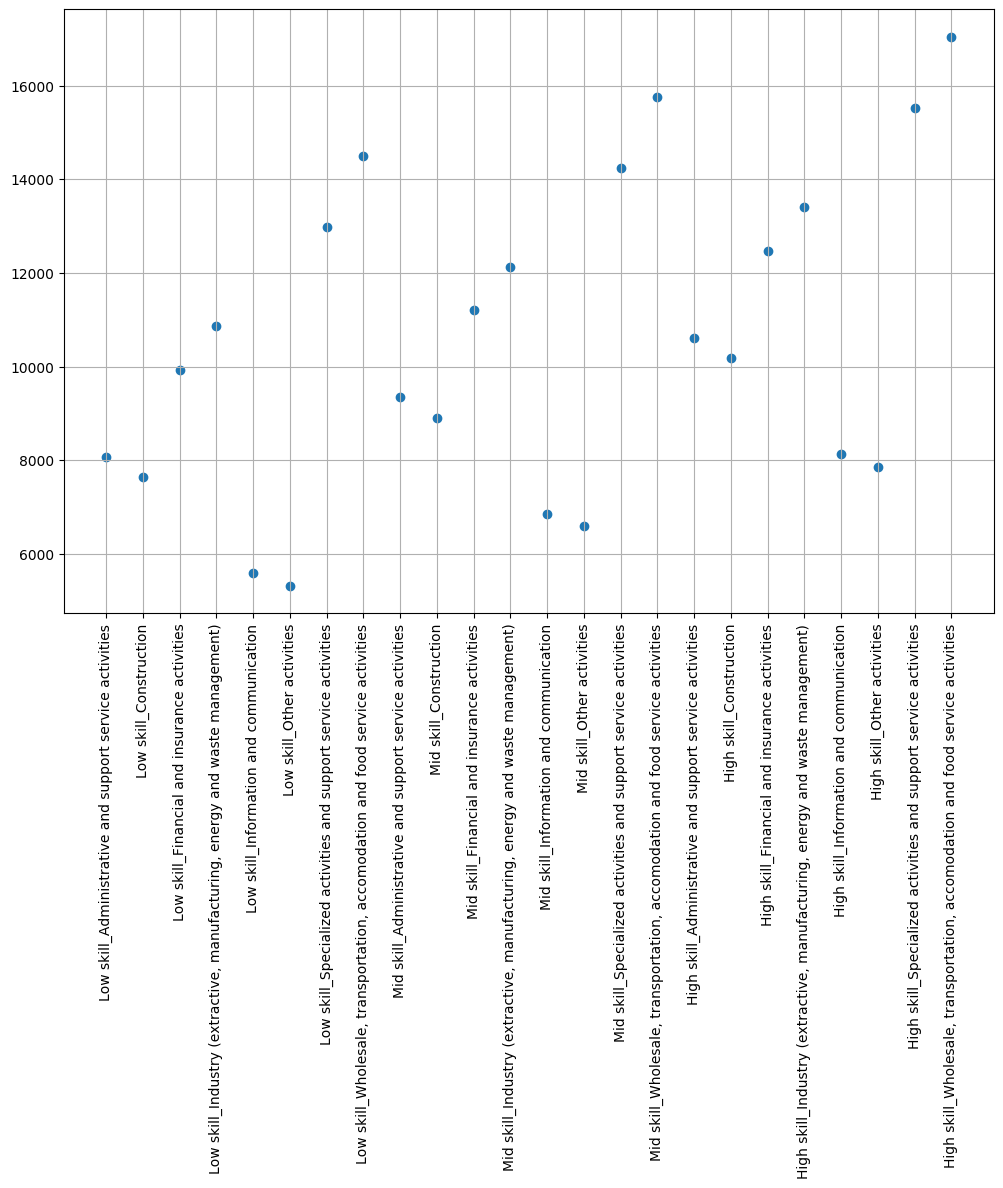

In [304]:
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.grid()
plt.scatter(values_intersection_titles,values_intersection)
plt.xticks(rotation=90)
plt.savefig("./industry_demand_level_predicted.png")